# Open Exploration: Scenario Discovery

Scenario Discovery using PRIM to identify combinations of input parameters that result in specific outcomes under conditions of deep uncertainty.

In [1]:
#import
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from ema_workbench import (Scenario, Policy, MultiprocessingEvaluator, perform_experiments, ema_logging)
from ema_workbench import Samplers
from ema_workbench import save_results, load_results
from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from SALib.analyze import sobol
from ema_workbench.analysis import prim, pairs_plotting

from problem_formulation import get_model_for_problem_formulation
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

In [2]:
# Import the results from the BAU exploratory modelling results
# data = './results/openexploration_BAU.tar.gz'

data = './results/behaviour_run_10000sc_refpol.tar.gz'

In [3]:
# Define KPIs
KPIs = ['Expected Annual Damage', 'Expected Number of Deaths', 'RfR Investment Costs',
            'Dike Investment Costs','Evacuation Costs', 'Total Investment Costs']

# focus on number of deaths
main_KPI = 'Expected Number of Deaths'

We chose Expected Number of Deaths as our main KPI here because it represents the impact on human life and safety. While expected annual damage is as important, it does not directly impact the affect on human life (it affects infrastructure thus related to money which we think could be managed). Thus, the expected number of deaths is chosen. 

In [4]:
# Load the results and convert outcomes to DataFrame
experiments, outcomes = load_results(data)
experiments = pd.DataFrame(experiments)
outcomes = pd.DataFrame(outcomes)

[MainProcess/INFO] results loaded successfully from c:\Users\athaa\Desktop\epa141A_open\final assignment\results\behaviour_run_10000sc_refpol.tar.gz


In [5]:
# Remove costs columns from outcomes dataframe because its 0
outcomes_without_costs = outcomes.drop(columns=['RfR Investment Costs', 'Dike Investment Costs', 
                                                    'Evacuation Costs', 'Total Investment Costs'])

In [6]:
# Combine experiments and outcomes
results = pd.concat([experiments, outcomes], axis=1)

In [7]:
# define uncertainties 
uncertainties = ['A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_Brate', 'A.1_pfail',
       'A.2_Bmax', 'A.2_Brate', 'A.2_pfail', 'A.3_Bmax', 'A.3_Brate',
       'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_pfail', 'A.5_Bmax',
       'A.5_Brate', 'A.5_pfail', 'discount rate 0', 'discount rate 1',
       'discount rate 2']

In [8]:
# Separate features (x) and outcomes (y)
x = results.loc[:, uncertainties]
y = outcomes[main_KPI]

PRIM algorithm is chosen for scenario discovery due to its ability to handle high-dimensional data and being able to identify combinations of input parameters that result in specific outcomes. In this case, it is well suited to discover regions of the input space in which the number of deaths is prevalent. According to Bryant & Lempert (2010), PRIM is especially useful in the context of deep uncertainty where traditional scenario planning methods can fall short. 

We decide to set the threshold to 0.75, meaning, at least 75% of the data points within the box are greater than the 80th percentile that we also set. By doing so, we could identify boxes that are highly relevant, containing a significant proportion of the desired outcome. 

In [9]:
# Define high-damage cases based on top 20%
eighty_q = y.quantile(0.8)
y_binary = (y > eighty_q).astype(int).values

[MainProcess/INFO] 10000 points remaining, containing 2000 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.109, coverage: 0.545, density: 1.0 restricted_dimensions: 3


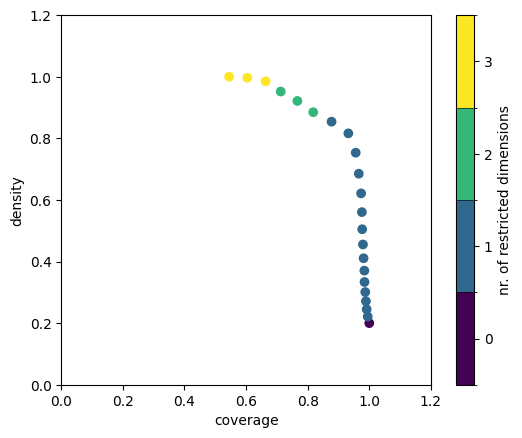

In [10]:
ema_logging.log_to_stderr(ema_logging.INFO)

prim_alg = prim.Prim(x, y_binary, threshold=0.75, peel_alpha=0.1)
box1 = prim_alg.find_box()
box1.show_tradeoff()
plt.show()

In [11]:
# see where coverage is higher than 0.8 and density is higher than 0.6
potentials = box1.peeling_trajectory
potentials = potentials[(potentials.coverage > 0.8)
                         & (potentials.density > 0.6)]
potentials

,coverage,density,id,k,mass,mean,n,res_dim
11,0.9735,0.621251,11,1947,0.3134,0.621251,3134,1
12,0.9660,0.685106,12,1932,0.2820,0.685106,2820,1
13,0.9560,0.753349,13,1912,0.2538,0.753349,2538,1
14,0.9320,0.816112,14,1864,0.2284,0.816112,2284,1
15,0.8775,0.854015,15,1755,0.2055,0.854015,2055,1
16,0.8180,0.884803,16,1636,0.1849,0.884803,1849,2


In [12]:
chosen_box = potentials[potentials.density == potentials.density.max()]
chosen_box_id = int(chosen_box.iloc[0].name)
chosen_box_id

16

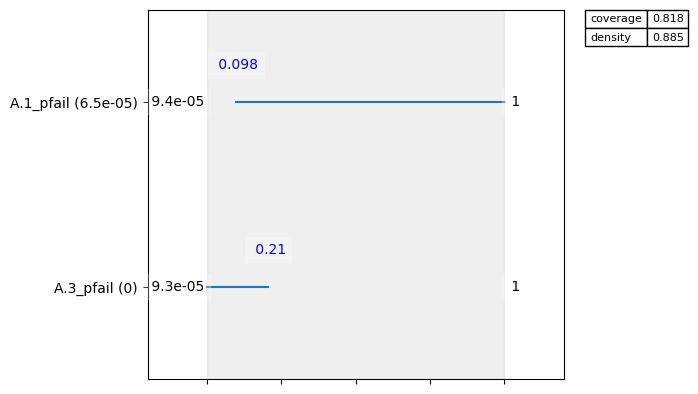

In [13]:
box1.select(chosen_box_id)
box1.inspect(style='graph')
plt.show()

The PRIM analysis showed A.1pfail and A.3_pfail which represents the probability of the dikes at those locations withstanding the hydraulic load. The range for A.1_pfail shows 0.00079 to 1 while A.3_pfail shows 0.00099 to 1. The blue number represents the constrained range starting point and the endpoint (1) represents the end point. 

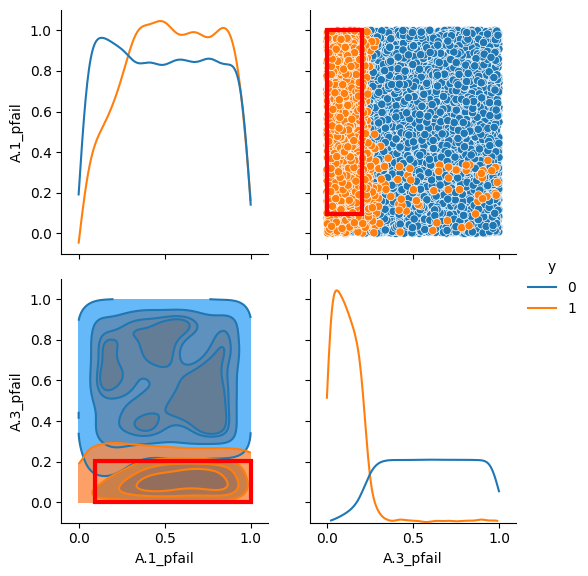

In [14]:
box1.select(chosen_box_id)
box1.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(6,6)
plt.show()

The scatter and density plots shows the distribution of low risk (blue) and high risk (red) outcomes concerning the probability that the dike (in A1 and A3) will withstand the hydraulic load. Overall, high-risk outcomes are linked to low dike resistance at A.1 and A.3, meaning risk increases when both have low chances of withstanding hydraulic loads. In more detail:

**Top-left plot (A.1_pfail):**  
High-risk outcomes (orange line) are more frequent when A.1 has a low chance of withstanding the hydraulic load. The risk is concentrated at lower values.

**Top-right plot (A.1_pfail vs. A.3_pfail):**  
High-risk outcomes (orange dots) mostly appear when both A.1 and A.3 have low failure resistance. These cluster in the lower-left corner of the plot.

**Bottom-left plot (A.3_pfail vs. A.1_pfail):**  
High-risk scenarios are common when A.3_pfail is low, especially if A.1_pfail is also low, as shown in the contour patterns.

**Bottom-right plot (A.3_pfail):**  
High-risk outcomes are more likely at very low A.3_pfail values, with a sharp peak indicating concentrated risk.

In [15]:
# Inspect the parameter limits from the chosen box
limits = box1.box_lims[chosen_box_id]
limits

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,A.4_Bmax,A.4_Brate,A.4_pfail,A.5_Bmax,A.5_Brate,A.5_pfail,discount rate 0,discount rate 1,discount rate 2
0,0,30.013965,"{1.5, 10.0, 1.0}",0.097517,30.021586,"{1.5, 10.0, 1.0}",0.000002,30.000607,"{1.5, 10.0, 1.0}",0.000093,30.014975,"{1.0, 10.0, 1.5}",0.000067,30.001589,"{1.0, 10.0, 1.5}",0.000054,"{1.5, 2.5, 3.5, 4.5}","{1.5, 2.5, 3.5, 4.5}","{1.5, 2.5, 3.5, 4.5}"
1,132,349.991023,"{1.5, 10.0, 1.0}",0.999923,349.973797,"{1.5, 10.0, 1.0}",0.999940,349.973957,"{1.5, 10.0, 1.0}",0.205517,349.971763,"{1.0, 10.0, 1.5}",0.999912,349.978822,"{1.0, 10.0, 1.5}",0.999950,"{1.5, 2.5, 3.5, 4.5}","{1.5, 2.5, 3.5, 4.5}","{1.5, 2.5, 3.5, 4.5}"


In [16]:
# Interpret the limits of the box (the minimum and maximum values of the parameters that define the box)

print("Uncertainties limits of the box:")
for param, (lower_bound, upper_bound) in limits.items():
    print(f"{param}: {lower_bound} to {upper_bound}")

Uncertainties limits of the box:
A.0_ID flood wave shape: 0 to 132
A.1_Bmax: 30.01396514690017 to 349.9910227733934
A.1_Brate: {1.5, 10.0, 1.0} to {1.5, 10.0, 1.0}
A.1_pfail: 0.09751661662622241 to 0.999922980955986
A.2_Bmax: 30.02158559602801 to 349.97379709384313
A.2_Brate: {1.5, 10.0, 1.0} to {1.5, 10.0, 1.0}
A.2_pfail: 1.9959506098141235e-06 to 0.9999404949747698
A.3_Bmax: 30.000606952073344 to 349.9739572744991
A.3_Brate: {1.5, 10.0, 1.0} to {1.5, 10.0, 1.0}
A.3_pfail: 9.29861781064584e-05 to 0.20551709770793497
A.4_Bmax: 30.014975478575582 to 349.9717632673227
A.4_Brate: {1.0, 10.0, 1.5} to {1.0, 10.0, 1.5}
A.4_pfail: 6.688421216571271e-05 to 0.9999120399707516
A.5_Bmax: 30.001589451292872 to 349.97882166577955
A.5_Brate: {1.0, 10.0, 1.5} to {1.0, 10.0, 1.5}
A.5_pfail: 5.432639942715865e-05 to 0.999949654723484
discount rate 0: {1.5, 2.5, 3.5, 4.5} to {1.5, 2.5, 3.5, 4.5}
discount rate 1: {1.5, 2.5, 3.5, 4.5} to {1.5, 2.5, 3.5, 4.5}
discount rate 2: {1.5, 2.5, 3.5, 4.5} to {1.5, 

In [17]:
# Filter the experiments to only include those within the defined box limits (only on the relevant uncertainties

box_uncertainties = ['A.1_pfail', 'A.3_pfail']

results_box = results.copy()
for var in box_uncertainties:
    low, high = limits[var]
    results_box = results_box[(results_box[var] >= low) & (results_box[var] <= high)]

results_box.head()


,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.5_DikeIncrease 2,scenario,policy,model,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths,Total Investment Costs
8,90,180.232142,10.0,0.192214,73.508499,1.0,0.807280,114.569131,1.5,0.130343,...,0,10008,Policy 0,dikesnet,2.944231e+09,0,0.0,0.0,2.206400,0.0
9,6,93.517454,1.0,0.889155,96.832719,10.0,0.314095,348.435365,1.5,0.012347,...,0,10009,Policy 0,dikesnet,2.308417e+09,0,0.0,0.0,3.289976,0.0
23,97,320.343542,1.5,0.111144,214.976948,1.0,0.745405,303.404374,1.5,0.069001,...,0,10023,Policy 0,dikesnet,3.375532e+09,0,0.0,0.0,1.903662,0.0
37,50,127.905332,10.0,0.811302,183.043349,10.0,0.147854,311.317473,1.0,0.171009,...,0,10037,Policy 0,dikesnet,2.736318e+09,0,0.0,0.0,3.512302,0.0
39,84,49.891097,10.0,0.388167,130.381508,10.0,0.729424,124.392040,1.5,0.107307,...,0,10039,Policy 0,dikesnet,3.033119e+09,0,0.0,0.0,3.890932,0.0


In [18]:
# Number of scenarios in the box
print(f"Number of scenarios in the box: {len(results_box)}")

Number of scenarios in the box: 1849


In [19]:
# Drop the non numeric columns
results_box_numeric = results_box.drop(columns=['policy', 'model'])

# export the results box into a csv file
results_box_numeric.to_csv('./results/scenariodis_prim_box.csv')

In [20]:
# Identify the worst-case scenario of the box
worst_case_index = results_box_numeric[main_KPI].idxmax()
worst_case = results_box_numeric.loc[[worst_case_index]]

After identifying high-risk scenarios using PRIM, focusing on expected deaths and the chances of dike failure at A.1 and A.3, we wanted to make sure that the scenarios we selected for deeper analysis were as diverse as possible.

To do this, we looked at two key indicators: Expected Number of Deaths and Expected Annual Damage. We will start by normalizing these values so we could fairly compare how different the scenarios are. Since no policies were applied in the experiments, cost wasn’t considered at this stage.

Next, we also calculated how different each scenario is from the others using a distance matrix.

In [21]:
#import standard scaler for normalization
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
# normalize the outcomes for fair distance calculation
scaler = StandardScaler()
normalized_outcomes = scaler.fit_transform(results_box_numeric[['Expected Number of Deaths', 'Expected Annual Damage']])

# distance matrix
distance_matrix = squareform(pdist(normalized_outcomes, metric='euclidean'))

Then, to select the most diverse scenario from the matrix, we first randomly chose one scenario to start with. Then, we keep adding the scenario that was most different from the ones we’d already picked. This is repeated until we have the number of scenarios we needed.

In [22]:
# Function to select most diverse scenarios
def select_diverse_scenarios(distance_matrix, num_scenarios):
    # Start with a random scenario
    selected_indices = [np.random.choice(range(distance_matrix.shape[0]))]
    for _ in range(num_scenarios - 1):
        min_distances = distance_matrix[selected_indices].min(axis=0)
        next_index = min_distances.argmax()
        selected_indices.append(next_index)
    return selected_indices

In [23]:
# Select most diverse scenarios
num_scenarios = 5
selected_indices = select_diverse_scenarios(distance_matrix, num_scenarios)
subset_scenarios = results_box_numeric.iloc[selected_indices]

# Include worst-case scenario explicitly if not already in the subset
if worst_case['scenario'].values[0] not in subset_scenarios['scenario'].values:
    subset_scenarios = pd.concat([subset_scenarios, worst_case], ignore_index=True)

This method helped us capture a broad range of possible high-risk situations. By selecting scenarios that are very different from one another, we can better explore which policies work well not just in average situations, but also in rare, high-impact flood events. These scenarios will be used in the next phase—Policy Discovery—to test how robust different strategies are under uncertainty.

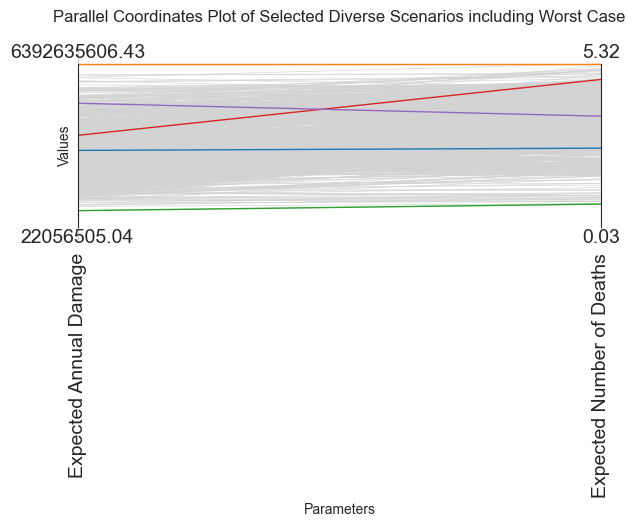

In [24]:
from ema_workbench.analysis import parcoords

# Create Parallel Coordinates Plot using parcoords
limits = parcoords.get_limits(outcomes_without_costs)
axes = parcoords.ParallelAxes(limits)

# Plot all scenarios with light grey lines
axes.plot(results_box, color='lightgrey', lw=0.5, alpha=0.9)

# Plot selected scenarios with distinct colors
for i, scenario in enumerate(subset_scenarios.index):
    axes.plot(subset_scenarios.loc[scenario, :], color=sns.color_palette()[i], lw=1)

plt.title('Parallel Coordinates Plot of Selected Diverse Scenarios including Worst Case\n')
plt.xlabel('Parameters')
plt.ylabel('Values')
plt.grid(True)
plt.show()

In [25]:
# Prepare selected scenarios for further analysis
# We only keep the uncertainty parameters, since outcomes and levers are not needed at this stage

# These scenarios will later be used to test various policy (lever) combinations
# and observe their impact on the outcomes

# Drop all outcome-related columns
outcome_columns = [
    'Expected Annual Damage',
    'Dike Investment Costs',
    'RfR Investment Costs',
    'Evacuation Costs',
    'Expected Number of Deaths',
    'Total Investment Costs'
]

subset_scenarios = subset_scenarios.drop(columns=outcome_columns)

# Drop levers
subset_scenarios = subset_scenarios.drop(columns=['0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0',
       '1_RfR 1', '1_RfR 2', '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0',
       '3_RfR 1', '3_RfR 2', '4_RfR 0', '4_RfR 1', '4_RfR 2',
       'EWS_DaysToThreat', 'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1',
       'A.1_DikeIncrease 2', 'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1',
       'A.2_DikeIncrease 2', 'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1',
       'A.3_DikeIncrease 2', 'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1',
       'A.4_DikeIncrease 2', 'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1',
       'A.5_DikeIncrease 2'])

In [26]:
# The rename subset_scenarios to match the expected format for further analysis
subset_scenarios = subset_scenarios.rename(columns={'scenario': 'Run ID'})

# save
subset_scenarios.to_csv('./results/scenariodis_selected_scenarios.csv', index=False)